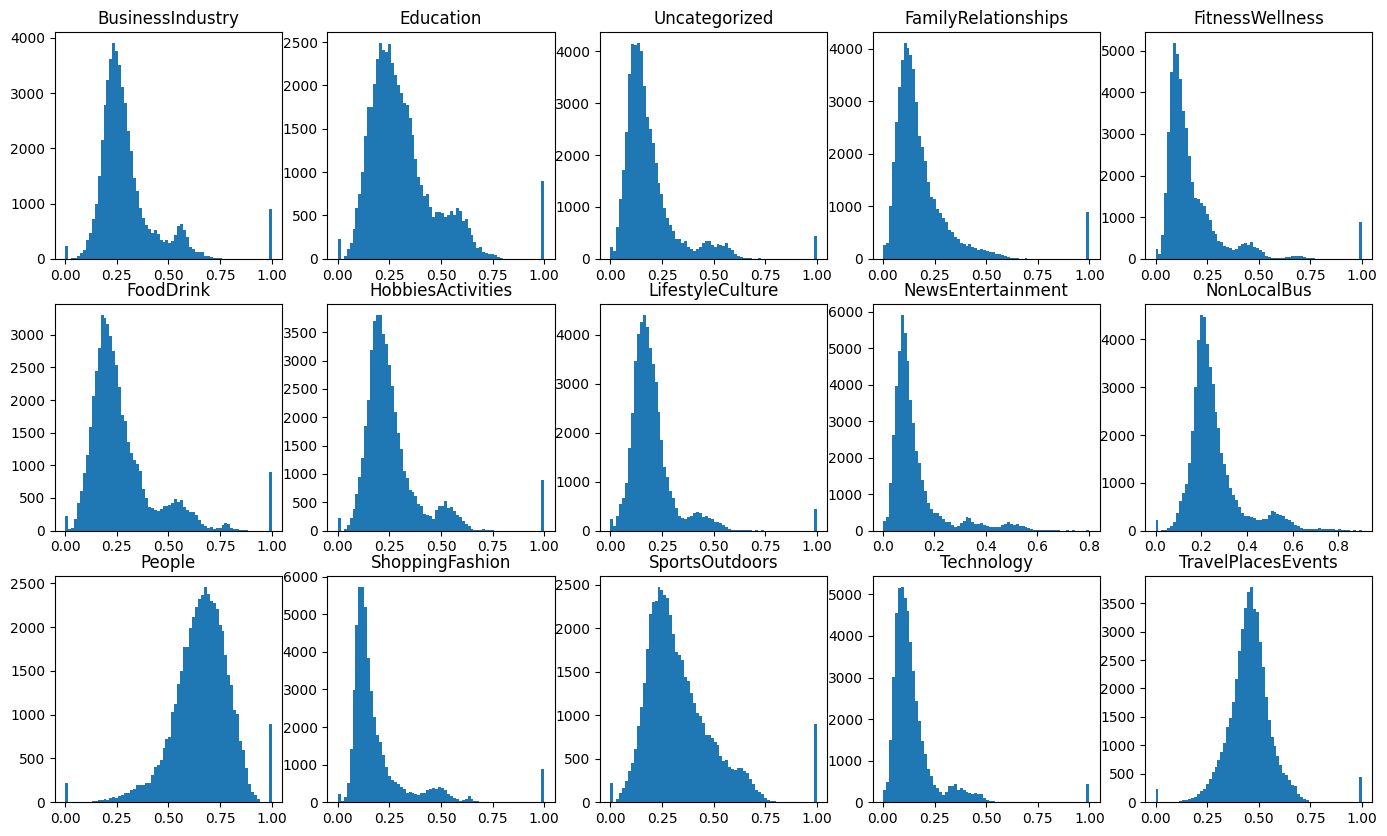

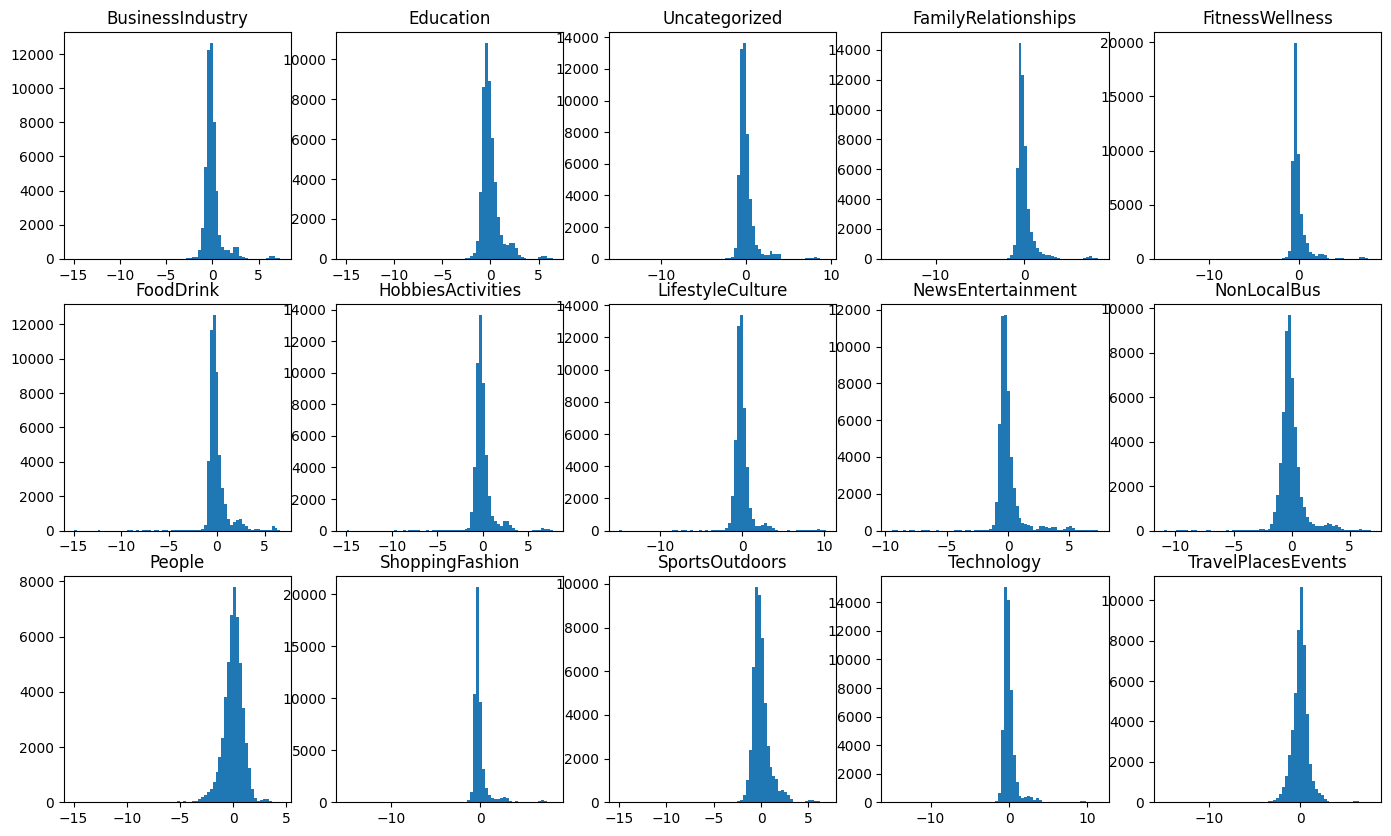

In [19]:
from utils.load import make_total_df,get_feature_names, get_indv_df
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
from sklearn.ensemble import RandomForestRegressor 
import matplotlib.pyplot as plt
df = make_total_df()
from src.Visualisations.distributions import julie_dist

#df = df.drop("Y_labels", axis=1)

In [22]:
df

,FBCosDist_BusinessIndustry.,FBCosDist_Education.,FBCosDist_FamilyRelationships.,FBCosDist_FitnessWellness.,FBCosDist_FoodDrink.,FBCosDist_HobbiesActivities.,FBCosDist_LifestyleCulture.,FBCosDist_NewsEntertainment.,FBCosDist_NonLocalBus.,FBCosDist_People.,...,FBManDist_LifestyleCulture.,FBManDist_NewsEntertainment.,FBManDist_NonLocalBus.,FBManDist_People.,FBManDist_ShoppingFashion.,FBManDist_SportsOutdoors.,FBManDist_Technology.,FBManDist_TravelPlacesEvents.,FBManDist_Uncategorized.,Y_labels
c_to_c,,,,,,,,,,,,,,,,,,,,,
AG_AE,0.261507,0.190169,0.045053,0.104336,0.253270,0.211779,0.117196,0.074938,0.223101,0.711156,...,14.782017,54.270207,242.646467,32.375634,10.206340,12.926806,8.118248,34.422627,17.015340,5488.0
AL_AE,0.236488,0.073067,0.073446,0.089928,0.119030,0.175246,0.194526,0.069180,0.202676,0.713172,...,12.415483,29.101487,172.894663,17.330872,5.620284,9.527579,5.938691,32.890397,10.196431,2101.0
AL_AG,0.237967,0.216138,0.090740,0.111809,0.224615,0.223379,0.187709,0.101999,0.229894,0.717840,...,15.266687,57.484249,259.423768,32.483852,10.078030,15.072849,9.026726,38.381617,16.959543,641.0
AM_AE,0.299419,0.099453,0.111057,0.100574,0.165536,0.196102,0.148088,0.030531,0.189267,0.665114,...,10.208594,21.222717,139.262034,12.294202,6.258551,5.158487,6.190173,23.436977,8.983505,3580.0
AM_AG,0.300475,0.255487,0.151110,0.078193,0.232395,0.181091,0.156594,0.076052,0.212817,0.652625,...,13.962780,55.035863,234.387755,29.894039,9.972139,13.802836,7.667930,27.837048,16.375097,360.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW_WS,0.251044,0.217158,0.113933,0.110997,0.259087,0.267729,0.108388,0.047541,0.174764,0.685191,...,10.430257,32.368074,156.600510,16.298196,6.142297,11.530616,6.411204,20.426814,11.332215,1138.0
ZW_XK,0.297909,0.251345,0.221944,0.123359,0.169269,0.303709,0.240973,0.131526,0.294409,0.716584,...,13.626210,40.364884,238.444516,19.910932,10.188259,14.149003,10.074814,33.647790,13.373483,262.0
ZW_YT,0.344767,0.405853,0.241724,0.131366,0.342396,0.293738,0.078400,0.051409,0.185660,0.752413,...,9.110514,32.695442,150.038638,17.744156,5.301217,11.648165,6.363004,17.232944,10.015898,1650.0


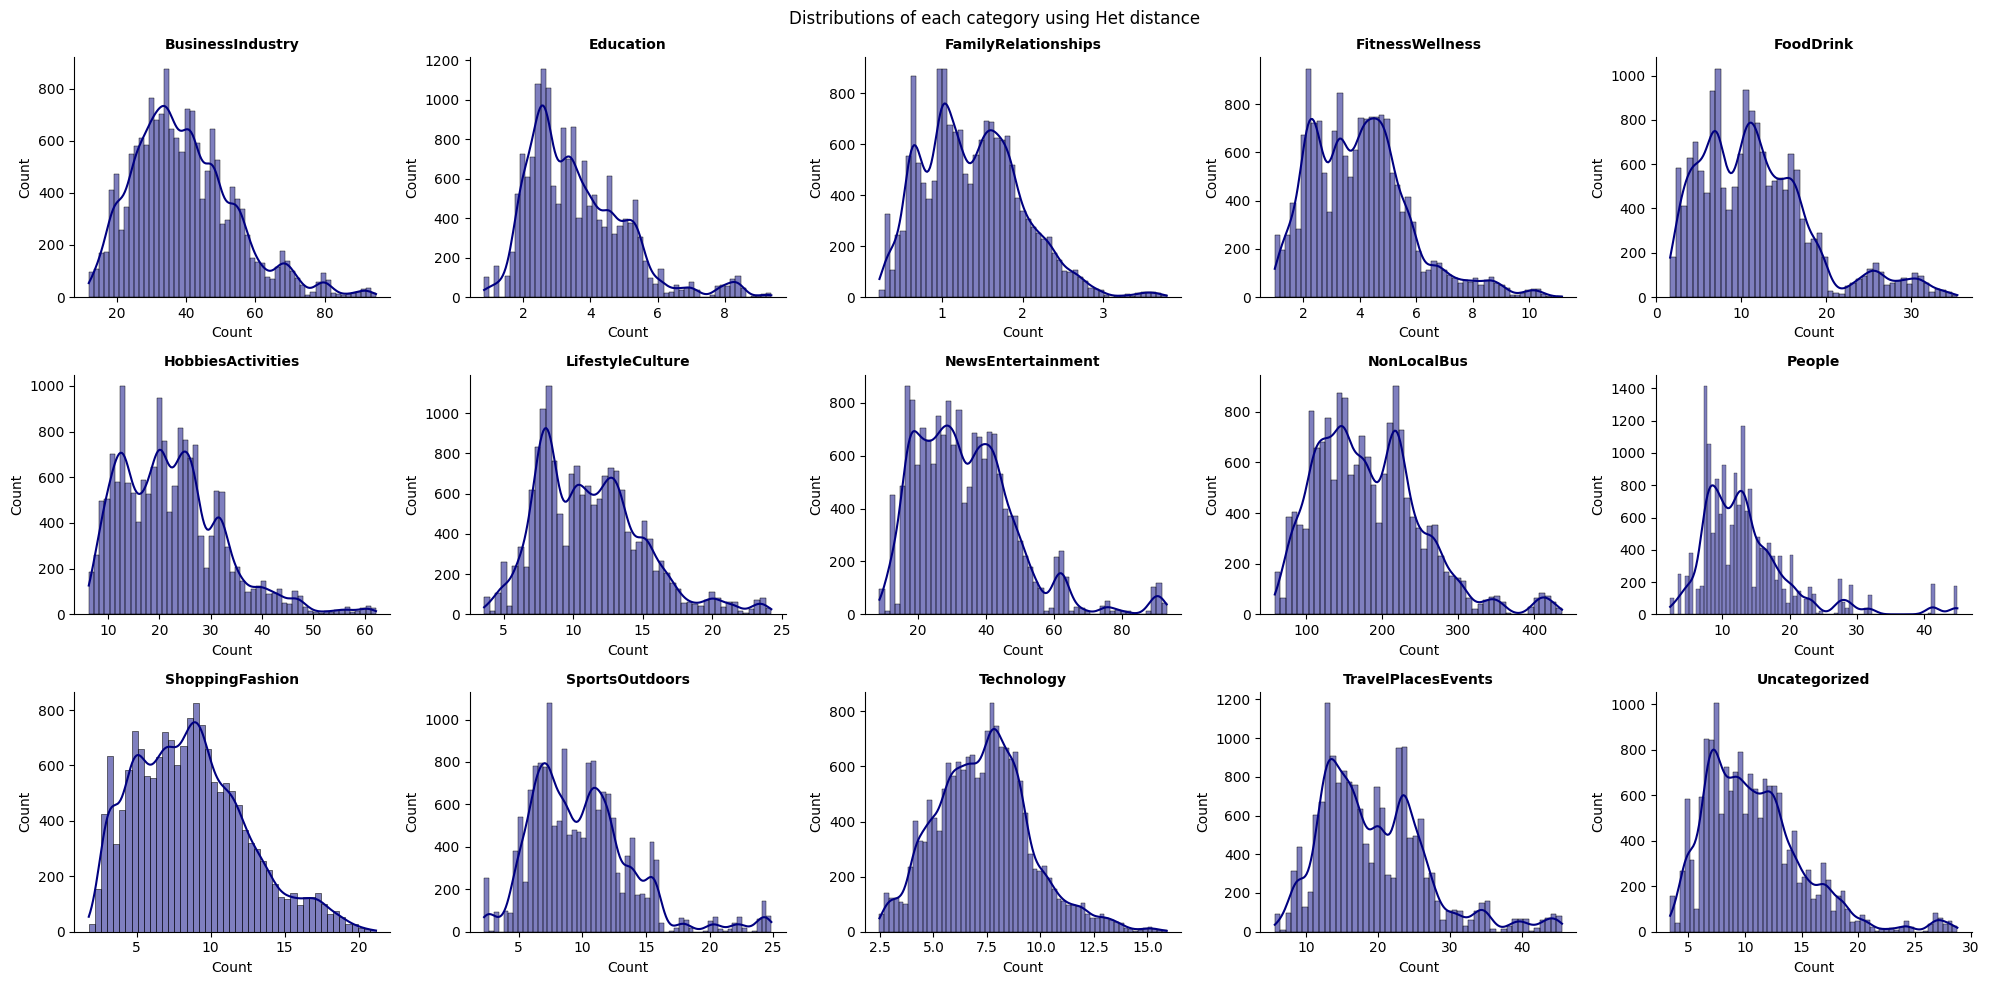

In [25]:
from src.Visualisations.distributions import julie_dist



julie_dist(df, 'Het')

In [26]:


from sklearn.linear_model import LassoCV
import pandas as pd
from sklearn.preprocessing import StandardScaler
from utils.load import load_everthing_old
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



def train_lr_only_dist():
    distance = pd.read_csv("data/distance_data/processed_distances.csv")
    X_dict, Y_dict = load_everthing_old()

    df_filled = distance.fillna(0)
    df_arr = df_filled.to_numpy().reshape(-1, 1)
    scaler = StandardScaler()
    X = scaler.fit_transform(df_arr)
    Y = [i[0] for i in Y_dict.values()]
    Y = np.log10(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)



    lr = LassoCV(max_iter= 100000, tol= 0.001).fit(X_train, y_train)

    prediction = lr.predict(X_test)
    r2 = r2_score(y_test, prediction)

    return r2


def lf():

    labels = ['All data with distance', 'All data without distance', 'Distance']
    dist_r2 = train_lr_only_dist()
    values = [0.62, 0.56, dist_r2]
    barWidth = 0.5
    r1 = np.arange(len(values))
    plt.bar(r1, values, width=barWidth, color='blue')

    plt.xticks([r for r in range(len(values))], labels)

    # Set plot title and axis labels
    plt.title('R-squared score for lr all data with and without distance and just distance')
    plt.xlabel('Dataset')
    plt.ylabel('R-squared Score')

    # Show the plot
    #plt.savefig('plots/r2_comparisons_lr.png')
    plt.show()

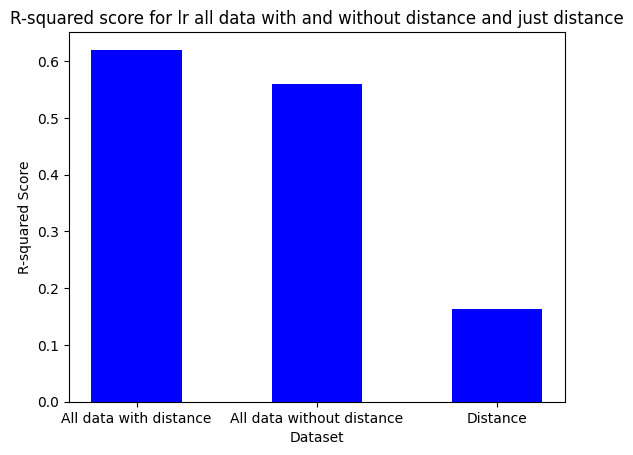

In [27]:
lf()